# TouchPass Analysis

The data for this analysis is from April 2021 and comes from the TouchPass API. This analysis will attempt to answer several questions (1) How many passengers reached their monthly fare cap limit? and (2) How long did those same passengers continue to ride once their monthly fare cap was reached?


In [1]:
# Import libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from arcgis.gis import GIS

pd.options.display.max_columns = 999

We'll go ahead and sign into ArcGIS Online to take advantage of some plotting and mapping capabilities.

In [2]:
# sign into ArcGIS Online
username = os.environ.get('ArcGIS Username')
password = os.environ.get('AGOL Password')

gis = GIS('https://www.arcgis.com', username, password)

Next, we'll pass in the parameters to the TouchPass API and then make the call to the API.

In [3]:
# define parameters
url = 'https://touchpass.com/ams/rest/v1/reporting/faretx/'
api_key = os.environ.get('TOUCHPASS_API_KEY')

start = '2021-04-01T10:00:00Z'
end = '2021-05-01T04:00:00Z'

headers = {
    'accept': 'application/json',
    'Api-Token': api_key,
    'Agency-ID': '9K7A4H9JHRVQ'
}

In [72]:
%%time

# call api and save to variable
response = requests.get(url + start + '/' + end, headers=headers).json()

# write response to dataframe
df = pd.DataFrame(response)

print('Finished reading {:,} transactions'.format(len(df)))

Finished reading 8,837 transactions
Wall time: 2.19 s


In [70]:
# preview data
df.head(3)

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
0,STORED_VALUE,8002571016314305,Half Priced,North Asheboro Park & Ride,169,10,35.746280,-79.807270,125,NaN,2021-04-01 06:08:15.149000-04:00,2021-04-01,06:08:15.149000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
1,MONTHLY_CAP_REACHED,8053364541245139,Employee,Coble Transportation Center,100,20,36.093318,-79.959420,0,NaN,2021-04-01 06:09:42.115000-04:00,2021-04-01,06:09:42.115000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
2,TRIP_PASS,8082440300373422,Half Priced,High Point Terminal (Outer Slip),225,3,35.957388,-80.007166,0,Half Fare 10 Ride,2021-04-01 06:11:52.173000-04:00,2021-04-01,06:11:52.173000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."


The dataframe above gives us a preview of what the data looks like. Let's take another look at it before we start to process it.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8837 entries, 0 to 8836
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   txId            8837 non-null   int64  
 1   ts              8837 non-null   object 
 2   type            8837 non-null   object 
 3   mediaUsed       8837 non-null   object 
 4   mediaType       8837 non-null   object 
 5   cardNumber      8837 non-null   object 
 6   fareType        8837 non-null   object 
 7   accountId       8837 non-null   int64  
 8   stopName        7372 non-null   object 
 9   stopId          7372 non-null   object 
 10  routeName       8837 non-null   object 
 11  latitude        8837 non-null   float64
 12  longitude       8837 non-null   float64
 13  reader          8837 non-null   object 
 14  readerPosition  8837 non-null   int64  
 15  fare            8837 non-null   int64  
 16  passUsed        3418 non-null   object 
 17  vehicle         1177 non-null   o

We need to convert `ts` or timestamp to a datetime object. We'll also convert the time to Eastern Standard time and create a few attributes for date and time. Then we'll drop a few columns that are of no interest to the analysis.

In [6]:
# Convert ts to a datetime object
df['ts'] = pd.to_datetime(df['ts'])
# Create new Date field and convert ts from UTC to local time
df['date'] = df['ts'].dt.tz_convert('US/Eastern')
# Create date only field
df['date_only'] = df['date'].dt.date
df['time_only'] = [dt.datetime.time(d) for d in df['date']]

In [7]:
cols_to_drop = ['txId', 'ts', 'mediaUsed', 'mediaType', 'accountId', 'reader', 'readerPosition', 'vehicle']

In [8]:
df.drop(cols_to_drop, axis=1, inplace=True)

Next, we'll convert our dataset to what Esri calls a spatially enabled dataframe. We can use the `longitude` and `latitude` attributes from the TouchPass data.

In [9]:
sdf = df.spatial.from_xy(df, 'longitude', 'latitude')

With our data set converted, we will visualize any missing data.

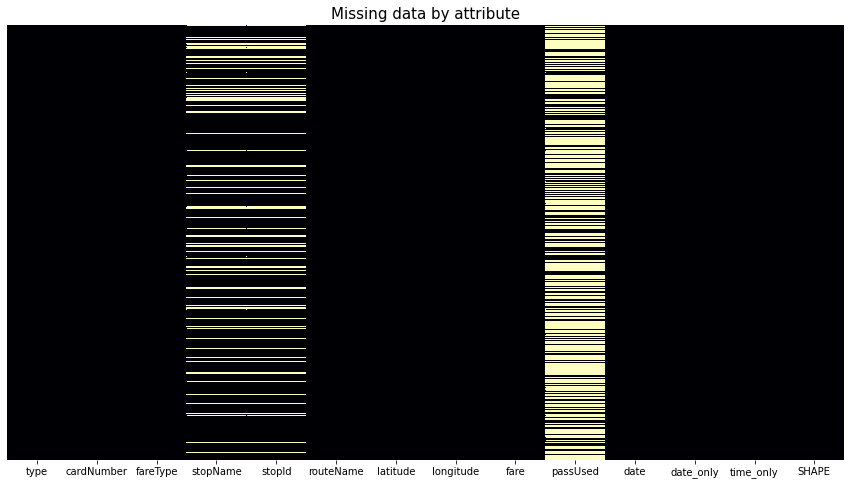

In [10]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(sdf.isnull(), cbar=False, cmap='magma')
plt.yticks([])
plt.title('Missing data by attribute', fontsize=15)
plt.show()

We can see that there are several missing values in the `stopName` and `stopId` attributes. There are even more missing values in the `passUsed` attributes.

Let's learn a little more about which passes have been used.

In [11]:
sdf['passUsed'].value_counts().to_frame()

,passUsed
Full Fare 10 Ride,1176
UNC XPass 2020-21,688
Half Fare 10 Ride,687
Half Fare 31 Day,220
Free One Way PT,114
One Way PT,107
Student 31 Day,105
Triad XPass 10 Ride,102
Student 10 Ride,79
Full Fare 31 Day,75


We can see that there are a variety of passes used on PART Express but the most common pass is the `Full Fare 10 Ride`. There also appears to be an equal number of `UNC XPass` and `Half Fare 10 Ride` passes used in the month of April. We also see that the `Triad XPass 10 Ride` is more popular than the `XPass 31 Day` pass? Are both of those part of the same program? The `XPass 31 Day` does not have the word 'Triad' in the name so they may not be related.

Let's see how many unique `cardNumber`s there are in the data set. We might assume this number represents the unique passengers in the system.

In [12]:
# unique users in data set
len(sdf['cardNumber'].unique())

835

We can see that there are 835 unique card numbers in the data set. 

Let's look at the types of transactions...

In [13]:
sdf['type'].value_counts().to_frame()

,type
TRANSFER,2549
TRIP_PASS,2299
STORED_VALUE,1304
DAILY_CAP_REACHED,952
CALENDAR_PASS,688
MONTHLY_CAP_REACHED,633
TIME_PASS,412


In [14]:
sdf['type'].value_counts(normalize=True).to_frame()*100

,type
TRANSFER,28.844631
TRIP_PASS,26.015616
STORED_VALUE,14.756139
DAILY_CAP_REACHED,10.772887
CALENDAR_PASS,7.785448
MONTHLY_CAP_REACHED,7.163064
TIME_PASS,4.662216


Looking at the types of transactions, we can see that `TRANSFER` is the most common. The second table shows that transfers account for nearly 29% of transactions in April in the TouchPass system. Only about 14% or 1,304 transactions used `STORED VALUE`.

In [15]:
# group by cardNumber and date
all_cards_by_date = sdf.groupby(['cardNumber', 'date_only']).size().to_frame()

# rename column
all_cards_by_date.rename(columns={0: 'Count'}, inplace=True)

In [16]:
all_cards_by_date.sum(level='cardNumber').sort_values(by='Count', ascending=False)[0:5]

,Count
cardNumber,
8043099273812846,100
8031827137994085,98
8029698325799824,88
8078732924645276,85
8002762949719302,85


The table above shows the top 5 card numbers by number of transactions. We can see that one passenger had 100 transactions in the month of April. Let's take a look at the average number of transactions by card number.

In [17]:
all_cards_by_date.mean(level='cardNumber').sort_values(by='Count', ascending=False)[0:5]

,Count
cardNumber,
8097183627485767,6.200000
8085476407283467,6.000000
7096424500002979,5.923077
8005074717035789,5.833333
7455472182477451,5.333333


We can see that the highest daily average is 6.2 transactions. This indicates that this passenger took as many as 7 trips on PART Express in one day.

Let's see how many stops passengers utilize.

In [18]:
all_cards_by_stop = sdf.groupby('cardNumber')['stopName'].nunique().sort_values(ascending=False)

In [19]:
all_cards_by_stop.to_frame()[0:5]

,stopName
cardNumber,
8005074717035789,8
8052861689715139,7
7989535757264325,7
8097183627485767,6
7055926279924935,6


The table shows the top five card numbers with the most unique stop activity. We can see that one passenger has utilized as many as 8 stops while two passengers accessed the system from 7 different stops in the month of April.

Now that we've learned a little more about our data set, let's dive into the transactions where passengers reached their monthly fare cap limit.

In [20]:
sdf['type'].value_counts()[['DAILY_CAP_REACHED', 'MONTHLY_CAP_REACHED']]

DAILY_CAP_REACHED      952
MONTHLY_CAP_REACHED    633
Name: type, dtype: int64

It looks like there are 633 observations where a passengers monthly fare cap was reached. Looking at the table above, the transactions where the monthly fare cap was reached only represents 7% of the data. 

Let's grab the `cardNumber` for those observations and filter the entire data set so we are only looking at passengers who reached their monthly fare cap.

In [21]:
# Create data set of card numbers for users who have reached their monthly fare cap
monthly_cap_cardNumbers = sdf.loc[
    (sdf['type'] == 'MONTHLY_CAP_REACHED') & (sdf['fareType'] != 'Employee'),
    'cardNumber'].unique()

We also went ahead and removed those observations where the `fareType` was `Employee`. This was done because every transaction for an employee was recorded as having reached their monthly fare cap. Even if it was the first tap of the month.

In [22]:
# Create data set of trips of those users who have reached their monthly fare cap
monthly_cap_user_trips = sdf[sdf['cardNumber'].isin(monthly_cap_cardNumbers)]

In [23]:
monthly_cap_user_trips.head()

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
9,STORED_VALUE,8040448200289326,Half Priced,Greensboro Depot,142,2,36.069193,-79.787014,125,NaN,2021-04-01 06:12:21.135000-04:00,2021-04-01,06:12:21.135000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
42,TRANSFER,8040448200289326,Half Priced,Coble Transportation Center,100,3,36.094024,-79.959068,0,NaN,2021-04-01 06:42:16.567000-04:00,2021-04-01,06:42:16.567000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
97,STORED_VALUE,8078732924645276,Full Fare,High Point Terminal (Outer Slip),225,3,35.957300,-80.007398,250,NaN,2021-04-01 07:41:54.949000-04:00,2021-04-01,07:41:54.949000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
108,STORED_VALUE,7836721698662976,Half Priced,Winston-Salem Transportation Center (L-1),198,1,36.099578,-80.245128,125,NaN,2021-04-01 08:09:22.070000-04:00,2021-04-01,08:09:22.070000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
109,TRANSFER,8078732924645276,Full Fare,Coble Transportation Center,100,23,36.093892,-79.958941,0,NaN,2021-04-01 08:09:57.353000-04:00,2021-04-01,08:09:57.353000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


In [24]:
monthly_cap_user_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 9 to 8800
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype                     
---  ------      --------------  -----                     
 0   type        314 non-null    object                    
 1   cardNumber  314 non-null    object                    
 2   fareType    314 non-null    object                    
 3   stopName    283 non-null    object                    
 4   stopId      283 non-null    object                    
 5   routeName   314 non-null    object                    
 6   latitude    314 non-null    float64                   
 7   longitude   314 non-null    float64                   
 8   fare        314 non-null    int64                     
 9   passUsed    11 non-null     object                    
 10  date        314 non-null    datetime64[ns, US/Eastern]
 11  date_only   314 non-null    object                    
 12  time_only   314 non-null    object               

So now we have a data set with only those transactions from users who reached their monthly fare cap AND are not employees. When do they reach their monthly fare cap and how often do they ride afterwards?

In [25]:
len(monthly_cap_user_trips[monthly_cap_user_trips['type'] == 'MONTHLY_CAP_REACHED'])

62

In [26]:
len(monthly_cap_user_trips['cardNumber'].unique())

4

We can see that there are 62 trips taken once the monthly fare cap has been reached and this activity is from only 4 users.

Let's find out when those passengers reached their monthly fare cap.

In [27]:
monthly_cap_user_trips.loc[
    monthly_cap_user_trips['type'] == 'MONTHLY_CAP_REACHED'
].groupby('cardNumber')['date_only'].min().to_frame().sort_values(by='date_only')

,date_only
cardNumber,
8078732924645276,2021-04-24
8040448200289326,2021-04-26
7836721698662976,2021-04-27
8092683798229972,2021-04-28


The table above shows when the four passengers reached their monthly fare cap level. We can see that the first passenger reached the limit on April 24 while the last passenger did not reach the limit until the second to last day of the month.

Let's take a look at their usage of the system throughout the entire month of April.

In [28]:
# create dataframe grouping users and dates
monthly_cap_user_trips_by_date = monthly_cap_user_trips.groupby(['cardNumber', 'date_only']).size().to_frame()

# rename column
monthly_cap_user_trips_by_date.rename(columns={0: 'Count'}, inplace=True)

In [29]:
# create a datetime index for the month of April
april_days = pd.date_range(start='2021-04-01', end='2021-04-30')

In [30]:
# replicate cardNumber to match length of datetime index
idx_1 = monthly_cap_user_trips_by_date.index.levels[0].repeat(len(april_days))

In [31]:
# replicate datetime index to match length of cardNumber
num_unique_cardNumber = len(monthly_cap_user_trips_by_date.index.levels[0])
idx_time = np.array([april_days.values] * num_unique_cardNumber).flatten()

In [32]:
# merge cardNumber index with datetime index
idx = list(zip(idx_1, idx_time))

In [33]:
# create a new dataframe with new cardNumber and datetime index
monthly_cap_user_trips_by_date_udpated = monthly_cap_user_trips_by_date.reindex(idx)

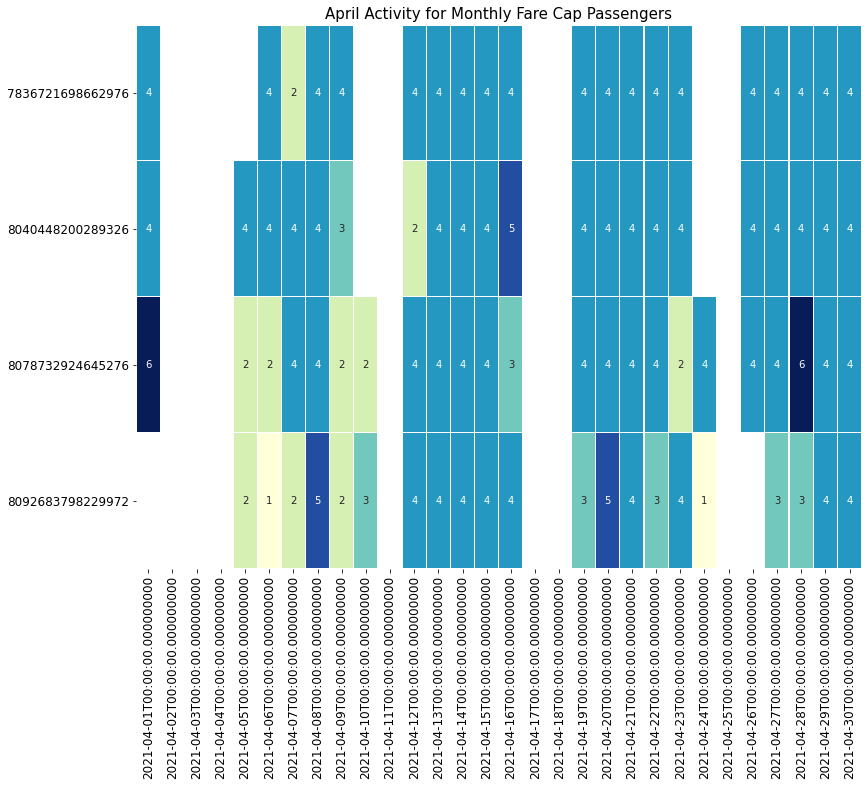

In [34]:
# create heatmap of passenger activity for the month of April
plt.figure(figsize=(13,10))
ax = sns.heatmap(
    monthly_cap_user_trips_by_date_udpated.unstack()['Count'], cmap='YlGnBu', annot=True, linewidths=0.2, cbar=False
)
plt.title('April Activity for Monthly Fare Cap Passengers', fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

Looking at the heatmap above, it seems that once the passengers reached their monthly fare cap, their behavior did not change much. The first passenger, `7836721698662976` reached their monthly fare cap on April 27. Their usage is consistent throughout the month of April. 

The first passenger in the heatmap, `8078732924645276`, was the first to reach their monthly fare cap. This occurred on April 24. While this passenger's trips were more sporadic than the first passenger, once they reached their fare cap limit, their usage did not change much.

Let's take a look at each of the four passenger's overall usage of the system.

In [35]:
monthly_cap_user_trips_by_date.sum(level='cardNumber').sort_values(by='Count', ascending=False)

,Count
cardNumber,
8078732924645276,85
8040448200289326,82
7836721698662976,78
8092683798229972,69


We can see that `8078732924645276` used their TouchPass account the most in the month of April with 85 transactions. Let us recall that this passenger was the first to reach their monthly fare cap limit on April 24. Passenger `8092683798229972	` had the fewest transactions and was also the last to reach their monthly fare cap which occurred on April 28. 

Let's look at their average daily transactions.

In [36]:
monthly_cap_user_trips_by_date.mean(level='cardNumber').sort_values(by='Count', ascending=False)

,Count
cardNumber,
8040448200289326,3.904762
7836721698662976,3.900000
8078732924645276,3.695652
8092683798229972,3.285714


The table above shows the average number of transactions by passenger. We can see that passenger `8040448200289326` has the highest daily average. Looking at the heatmap above, we can see this passenger is consistently making four transactions a day except for three days when they made 2 transactions, 3 transactions, and five transactions. Passenger `8078732924645276` may have the most transactions, they have the second lowest daily average transaction count. Looking at the heatmap above, we can see five days where this passenger made only two transactions and two days where they made six transactions. Passenger `8092683798229972` has the lowest daily average and looking at the heatmap, we can see a less consistent rider. Some days there is only one transaction while other days there are as many as five. And there is one week where this passenger recorded four transactions every day.

Let's dig into some of these trips so we can better understand how these passengers are using the system.

In [37]:
monthly_cap_user_trips.head(2)

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
9,STORED_VALUE,8040448200289326,Half Priced,Greensboro Depot,142,2,36.069193,-79.787014,125,NaN,2021-04-01 06:12:21.135000-04:00,2021-04-01,06:12:21.135000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
42,TRANSFER,8040448200289326,Half Priced,Coble Transportation Center,100,3,36.094024,-79.959068,0,NaN,2021-04-01 06:42:16.567000-04:00,2021-04-01,06:42:16.567000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


Let's take a look at Passenger `8092683798229972` first because they had the fewest trips and the most sporadic usage.

In [38]:
pass_with_least_trips = monthly_cap_user_trips[monthly_cap_user_trips['cardNumber'] == '8092683798229972']
pass_with_least_trips.head(2)

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
548,TRIP_PASS,8092683798229972,Full Fare,Coble Transportation Center,100,2,36.093591,-79.959406,0,Free One Way Accom,2021-04-05 06:45:21.132000-04:00,2021-04-05,06:45:21.132000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
717,STORED_VALUE,8092683798229972,Full Fare,NaN,NaN,22/23,36.075288,-79.958217,250,NaN,2021-04-05 14:38:17.847000-04:00,2021-04-05,14:38:17.847000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


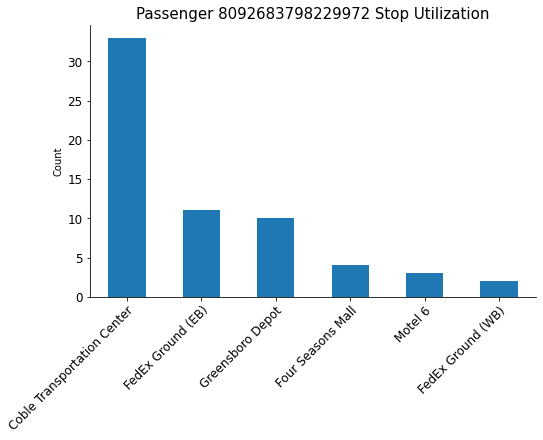

In [39]:
plt.figure(figsize=(8, 5))
ax = pass_with_least_trips.groupby('stopName').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Passenger 8092683798229972 Stop Utilization', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
sns.despine()
plt.show()

We can see that this passenger utilizes the CTC the most frequently and perhaps they work at FedEx Ground. What is interesting is we see boardings at FedEx Ground in both directions. The westbound boardings are somewhat puzzling as there is no activity at any stop in Kernersville or Winston-Salem which is where the westbound bus is heading after leaving FedEx Ground. There is activity at the Greensboro Depot and at Four Seasons Mall so we might assume this passenger lives in Greensboro and catches Route 2 at either the Greensboro Depot or Four Seasons Mall to make it to work at FedEx Ground. There is also activity at Motel 6. There are a few locations to grab a bite of food around that stop so perhaps this passenger utilizes the service on their break to get some lunch or a snack.

Let's take a look at this passengers activity on two separate days. We'll look at the 8th where they had five transactions and the 24th, where they had only one transaction. We'll isolate the 8th and create a new sequence attribute so we can track the movements throughout the day.

In [40]:
pass_with_least_trips[
    pd.to_datetime(pass_with_least_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-08', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
1968,STORED_VALUE,8092683798229972,Full Fare,Four Seasons Mall,153,2,36.040440,-79.841540,250,NaN,2021-04-08 11:01:45.377000-04:00,2021-04-08,11:01:45.377000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
1970,TRANSFER,8092683798229972,Full Fare,Greensboro Depot,142,2,36.069249,-79.787050,0,NaN,2021-04-08 11:15:17.625000-04:00,2021-04-08,11:15:17.625000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
1992,TRANSFER,8092683798229972,Full Fare,FedEx Ground (WB),285,17,36.110016,-80.034146,0,NaN,2021-04-08 12:31:43.164000-04:00,2021-04-08,12:31:43.164000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
2168,DAILY_CAP_REACHED,8092683798229972,Full Fare,FedEx Ground (EB),286,17,36.109801,-80.034406,250,NaN,2021-04-08 18:02:23.248000-04:00,2021-04-08,18:02:23.248000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
2180,DAILY_CAP_REACHED,8092683798229972,Full Fare,Coble Transportation Center,100,2,36.093182,-79.959294,0,NaN,2021-04-08 18:14:45.017000-04:00,2021-04-08,18:14:45.017000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


There is some interesting and I might argue unexplainable activity occurring with this passenger. The table above shows activity for April 8, 2021. The passenger boards Route 2 at Four Seasons Mall at 11:01 AM. They then use their TouchPass account for a free transfer at the Greensboro Depot on Route 2 at 11:15 AM. The next transactions is at the FedEx Ground (WB) stop on Route 17. How did they get to the FedEx location. There is no transaction in the data where this passenger boards Route 17 at the Coble Transportation Center. Perhaps the boarded Route 2 in Greensboro heading to the CTC. Once they arrived at the CTC, they utilized an Uber or Lyft to get to FedEx in time for their shift. If they took Route 2 from the Depot to the CTC at the 11:15 AM trip, they would have arrived at the CTC at 11:45 AM. The next Route 17 leaving the CTC heading west is not until 12:20 PM. However, at 12:31 PM, we see this passenger board Route 17 on the westbound trip. Did they ride into downtown Kernersville for lunch and then Uber back to finish their shift? This seems odd given that they would have just arrived to FedEx perhaps 30 minutes earlier. Then at 6:02 PM, the passenger boards Route 17 heading back to the CTC before transfering to Route 2 at 6:15 PM. This passengers morning trip has left us with more questions than answers and their evening trip appears to be straight forward.

Let's take a look at the 24th, where the passenger only has one transaction.

In [41]:
pass_with_least_trips[
    pd.to_datetime(pass_with_least_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-24', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
6831,STORED_VALUE,8092683798229972,Full Fare,Coble Transportation Center,100,2,36.093309,-79.959376,250,NaN,2021-04-24 18:27:43.454000-04:00,2021-04-24,18:27:43.454000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


The only transaction for April 24, occurred at the CTC at 6:28 PM. April 24th is a Saturday which means Route 17 was not running. This passenger had to utilize some other mode of transportation to get from possibly FedEx Ground to the CTC where they boarded Route 2 heading to Greensboro.

Let's look at one more trip. This time, we'll look at one where the passenger boarded at the Motel 6 stop.

In [42]:
pass_with_least_trips[pass_with_least_trips['stopName'] == 'Motel 6']['date_only']

2755    2021-04-12
4810    2021-04-19
5276    2021-04-20
Name: date_only, dtype: object

The table above shows that the passenger utilized the Motel 6 stop on three days. We will examine one of those days.

In [43]:
pass_with_least_trips[
    pd.to_datetime(pass_with_least_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-20', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
5276,STORED_VALUE,8092683798229972,Full Fare,Motel 6,101,22,36.076781,-79.958032,250,NaN,2021-04-20 08:06:02.818000-04:00,2021-04-20,08:06:02.818000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
5279,TRANSFER,8092683798229972,Full Fare,Coble Transportation Center,100,2,36.093537,-79.959364,0,NaN,2021-04-20 08:13:13.996000-04:00,2021-04-20,08:13:13.996000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
5332,DAILY_CAP_REACHED,8092683798229972,Full Fare,Greensboro Depot,142,2,36.069180,-79.787065,250,NaN,2021-04-20 12:09:23.675000-04:00,2021-04-20,12:09:23.675000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
5382,DAILY_CAP_REACHED,8092683798229972,Full Fare,FedEx Ground (EB),286,17,36.109676,-80.034830,0,NaN,2021-04-20 15:29:59.174000-04:00,2021-04-20,15:29:59.174000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
5394,DAILY_CAP_REACHED,8092683798229972,Full Fare,Coble Transportation Center,100,2,36.093418,-79.959420,0,NaN,2021-04-20 15:44:37.544000-04:00,2021-04-20,15:44:37.544000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


Again, there are some very interesting patterns. The passenger boards Route 22 at the Motel 6 stop at 8:06 AM and then transfers onto Route 2 at the CTC heading to Greensboro. Four hours later, we see the passenger board Route 2 at the Greensboro Depot heading to the CTC. This trip would have the passenger arriving at the CTC at 12:45 PM. The next transaction is at FedEx Ground (EB) at 3:30 PM. The passenger then boards Route 2 at the CTC heading to Greensboro at 3:44 PM. There is not much else around the FedEx Ground facility and I believe the times are not long enough for this person to be working. If they are, these are some very short shifts.  

We knew this passenger had some unusual trips when we looked at the heatmap above. Let's take a look at Passenger `7836721698662976` who had more consistent utilization of the service.

In [44]:
pass_with_2least_trips = monthly_cap_user_trips[monthly_cap_user_trips['cardNumber'] == '7836721698662976']
pass_with_2least_trips.head(2)

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
108,STORED_VALUE,7836721698662976,Half Priced,Winston-Salem Transportation Center (L-1),198,1,36.099578,-80.245128,125,NaN,2021-04-01 08:09:22.070000-04:00,2021-04-01,08:09:22.070000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
122,TRANSFER,7836721698662976,Half Priced,Coble Transportation Center,100,2,36.093659,-79.959388,0,NaN,2021-04-01 08:42:37.329000-04:00,2021-04-01,08:42:37.329000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


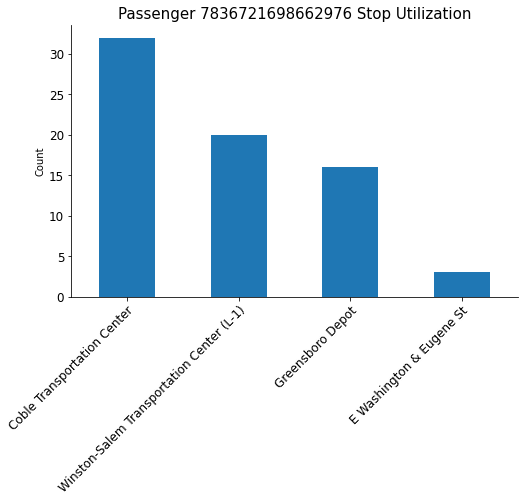

In [45]:
plt.figure(figsize=(8, 5))
ax = pass_with_2least_trips.groupby('stopName').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Passenger 7836721698662976 Stop Utilization', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
sns.despine()
plt.show()

The passenger utilized only four stops in the month of April and it appears that they travel between Winston-Salem and Greensboro regularly. We will dig into their trips. Looking at the heatmap, this passenger has four transactions most days. We'll check a few days to see if their trips are the same.

In [46]:
pass_with_2least_trips[
    pd.to_datetime(pass_with_2least_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-09', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
2330,STORED_VALUE,7836721698662976,Half Priced,Winston-Salem Transportation Center (L-1),198,1,36.099325,-80.245093,125,NaN,2021-04-09 08:12:04.388000-04:00,2021-04-09,08:12:04.388000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
2338,TRANSFER,7836721698662976,Half Priced,Coble Transportation Center,100,2,36.093635,-79.959352,0,NaN,2021-04-09 08:42:26.324000-04:00,2021-04-09,08:42:26.324000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
2433,DAILY_CAP_REACHED,7836721698662976,Half Priced,Greensboro Depot,142,2,36.069180,-79.787368,125,NaN,2021-04-09 15:46:02.639000-04:00,2021-04-09,15:46:02.639000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
2447,DAILY_CAP_REACHED,7836721698662976,Half Priced,Coble Transportation Center,100,1,36.093445,-79.959181,0,NaN,2021-04-09 16:16:16.423000-04:00,2021-04-09,16:16:16.423000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


Looking at their activity on April 9th, we can see this passenger boarded the 8:15 AM bus out of Winston-Salem and transfered to Route 2 at the CTC heading to Greensboro. Then the passenger boards the 3:45 PM bus out of Greensboro and transfers to Route 1 at the CTC that is heading back to Winston-Salem. This passenger also utilizes a half-priced fare. 

Let's take a look at a second day and see if their trip is the same.

In [47]:
pass_with_2least_trips[
    pd.to_datetime(pass_with_2least_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-27', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
7396,MONTHLY_CAP_REACHED,7836721698662976,Half Priced,Winston-Salem Transportation Center (L-1),198,1,36.099691,-80.245190,125,NaN,2021-04-27 08:11:19.088000-04:00,2021-04-27,08:11:19.088000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
7409,MONTHLY_CAP_REACHED,7836721698662976,Half Priced,NaN,NaN,DEFAULT,36.093728,-79.959526,0,NaN,2021-04-27 08:45:08.442000-04:00,2021-04-27,08:45:08.442000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
7604,MONTHLY_CAP_REACHED,7836721698662976,Half Priced,Greensboro Depot,142,2,36.069202,-79.786938,0,NaN,2021-04-27 17:14:51.005000-04:00,2021-04-27,17:14:51.005000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
7628,MONTHLY_CAP_REACHED,7836721698662976,Half Priced,Coble Transportation Center,100,1,36.093151,-79.959389,0,NaN,2021-04-27 17:47:00.767000-04:00,2021-04-27,17:47:00.767000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


The table above shows the trips taken on April 27th. They are similar to the trips the passenger took on April 9th. However, their trip in the afternoon began a few hours later at 5:15 PM. We can also see that the second trip in the morning is missing the stop name but there are valid coordinates. We can plot those on a map to confirm that this transfer took place at the CTC just as it had on April 9th.

In [48]:
m1 = GIS().map(zoomlevel=16)
m1.center = [36.093182, -79.959294]
m1.basemap = 'osm'

pass_with_2least_trips[
    (pd.to_datetime(pass_with_2least_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-27', format='%Y-%m-%d')) &
    (pass_with_2least_trips['routeName'] == 'DEFAULT')
].spatial.plot(
    map_widget=m1,
    marker_size=10
)

# show map
m1

C:\Users\miguelf.PARTNC\Anaconda3\envs\touchpass_v2\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\miguelf.PARTNC\Anaconda3\envs\touchpass_v2\lib\site-packages\arcgis\features\geo\_accessor.py:2569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data['OBJECTID'] = list(range(1, self._data.shape[0] + 1))


MapView(layout=Layout(height='400px', width='100%'))

The map above confirms that the transaction with the missing stop name did occur at the CTC.

We can see that this passenger appears to have more consistent trips between Winston-Salem and Greensboro while the times may vary.

Now we'll take a look at another passenger's activity, `8078732924645276`. This passenger had the most transactions in the month of April. Let's see where they are going.

In [49]:
pass_with_most_trips = monthly_cap_user_trips[monthly_cap_user_trips['cardNumber'] == '8078732924645276']
pass_with_most_trips.head(2)

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
97,STORED_VALUE,8078732924645276,Full Fare,High Point Terminal (Outer Slip),225,3,35.957300,-80.007398,250,NaN,2021-04-01 07:41:54.949000-04:00,2021-04-01,07:41:54.949000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
109,TRANSFER,8078732924645276,Full Fare,Coble Transportation Center,100,23,36.093892,-79.958941,0,NaN,2021-04-01 08:09:57.353000-04:00,2021-04-01,08:09:57.353000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


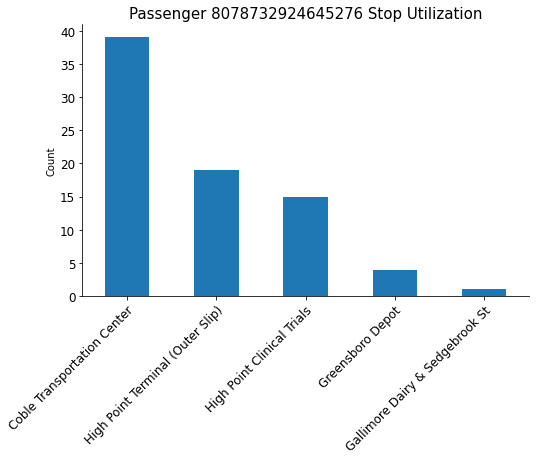

In [50]:
plt.figure(figsize=(8, 5))
ax = pass_with_most_trips.groupby('stopName').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Passenger 8078732924645276 Stop Utilization', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
sns.despine()
plt.show()

This activity is fairly interesting. We can see nearly 40 transactions at the CTC and about 20 transactions at the High Point Terminal. There are also about five transactions at the Greensboro Depot and some activity at stops that are along Route 22. Let's take a look at a few days.

In [51]:
pass_with_most_trips[
    pd.to_datetime(pass_with_most_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-01', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
97,STORED_VALUE,8078732924645276,Full Fare,High Point Terminal (Outer Slip),225,3,35.957300,-80.007398,250,NaN,2021-04-01 07:41:54.949000-04:00,2021-04-01,07:41:54.949000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
109,TRANSFER,8078732924645276,Full Fare,Coble Transportation Center,100,23,36.093892,-79.958941,0,NaN,2021-04-01 08:09:57.353000-04:00,2021-04-01,08:09:57.353000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
158,DAILY_CAP_REACHED,8078732924645276,Full Fare,NaN,NaN,22/23,36.047479,-79.954570,250,NaN,2021-04-01 11:27:34.522000-04:00,2021-04-01,11:27:34.522000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
163,DAILY_CAP_REACHED,8078732924645276,Full Fare,Coble Transportation Center,100,2,36.093243,-79.959852,0,NaN,2021-04-01 11:43:30.417000-04:00,2021-04-01,11:43:30.417000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
201,DAILY_CAP_REACHED,8078732924645276,Full Fare,Greensboro Depot,142,2,36.069214,-79.787195,0,NaN,2021-04-01 14:13:14.333000-04:00,2021-04-01,14:13:14.333000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
379,DAILY_CAP_REACHED,8078732924645276,Full Fare,Greensboro Depot,142,2,36.069308,-79.786807,0,NaN,2021-04-01 20:44:07.959000-04:00,2021-04-01,20:44:07.959000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


Looking at the passenger's activity on April 1st, we can see six transactions. They board Route 3 at 7:45 AM in High Point and then transfer to Route 23 at the CTC for the 8:15 AM trip. Then we see them board at an unknown stop at 11:27 AM and then they transfer onto Route 2 at the CTC at 11:43 AM heading to Greensboro. About two and a half hours later, we see them board Route 2 at the Greensboro Depot at 2:13 PM. Then there is no activity until 8:45 PM where they board Route 2 again at the Greensboro Depot. What is happening between 2:00 PM and 8:45 PM? Also, where are they boarding at 11:27 AM? Because there are valid coordinates, we can plot this transaction, just as we did above.

In [52]:
m2 = GIS().map(zoomlevel=16)
m2.center = [36.047847, -79.954559]
m2.basemap = 'osm'

pass_with_most_trips[
    (pd.to_datetime(pass_with_most_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-01', format='%Y-%m-%d')) &
    (pass_with_most_trips['routeName'] == '22/23')
].spatial.plot(
    map_widget=m2,
    marker_size=10
)

# show map
m2

C:\Users\miguelf.PARTNC\Anaconda3\envs\touchpass_v2\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\miguelf.PARTNC\Anaconda3\envs\touchpass_v2\lib\site-packages\arcgis\features\geo\_accessor.py:2569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data['OBJECTID'] = list(range(1, self._data.shape[0] + 1))


MapView(layout=Layout(height='400px', width='100%'))

This transaction occurs at High Point Clinical Trials, a stop that is frequently used by this passenger. April 1st was an unusual day for this passenger with 6 transactions. Typically they have four transactions and sometimes as few as 2. Let's take a look at another day.

In [53]:
pass_with_most_trips[
    pd.to_datetime(pass_with_most_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-13', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
3108,STORED_VALUE,8078732924645276,Full Fare,High Point Terminal (Outer Slip),225,3,35.957301,-80.007373,250,NaN,2021-04-13 06:40:09.385000-04:00,2021-04-13,06:40:09.385000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
3161,TRANSFER,8078732924645276,Full Fare,Coble Transportation Center,100,23,36.093636,-79.959078,0,NaN,2021-04-13 07:16:31.832000-04:00,2021-04-13,07:16:31.832000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
3396,DAILY_CAP_REACHED,8078732924645276,Full Fare,High Point Clinical Trials,146,23,36.047446,-79.954618,250,NaN,2021-04-13 17:00:10.468000-04:00,2021-04-13,17:00:10.468000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
3442,DAILY_CAP_REACHED,8078732924645276,Full Fare,NaN,NaN,DEFAULT,36.093830,-79.959126,0,NaN,2021-04-13 17:45:55.829000-04:00,2021-04-13,17:45:55.829000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


Here we can see a similar pattern. The passenger catches Route 3 out of High Point at 6:45 AM and transfers to Route 23 at 7:15 AM at the CTC. In the afternoon, they board Route 23 at High Point Clinical Trials and we can assume they transfer onto Route 3 at the CTC at 5:45 PM.

Let's take a look at the fourth and final passenger who reached their monthly fare cap.

In [54]:
pass_with_2most_trips = monthly_cap_user_trips[monthly_cap_user_trips['cardNumber'] == '8040448200289326']
pass_with_2most_trips.head(2)

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
9,STORED_VALUE,8040448200289326,Half Priced,Greensboro Depot,142,2,36.069193,-79.787014,125,NaN,2021-04-01 06:12:21.135000-04:00,2021-04-01,06:12:21.135000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
42,TRANSFER,8040448200289326,Half Priced,Coble Transportation Center,100,3,36.094024,-79.959068,0,NaN,2021-04-01 06:42:16.567000-04:00,2021-04-01,06:42:16.567000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


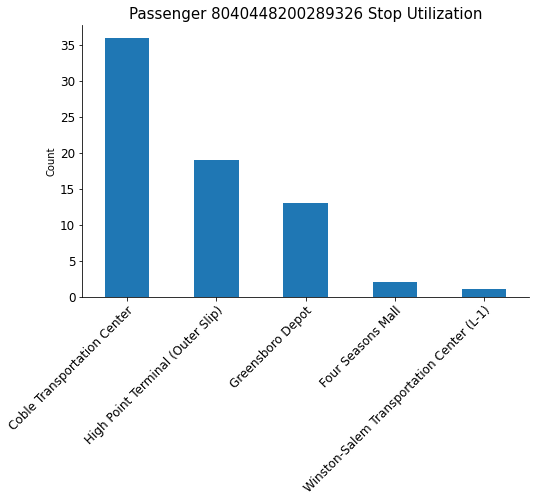

In [55]:
plt.figure(figsize=(8, 5))
ax = pass_with_2most_trips.groupby('stopName').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Passenger 8040448200289326 Stop Utilization', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
sns.despine()
plt.show()

This passenger appears to be a Triad traveler with transactions in High Point, Greensboro, and Winston-Salem. There appears to be only one or two transactions in Winston-Salem but we can examine that in a moment. Let's pick a day and see what their trip looks like.

In [56]:
pass_with_2most_trips[
    pd.to_datetime(pass_with_2most_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-05', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
509,STORED_VALUE,8040448200289326,Half Priced,Greensboro Depot,142,2,36.069202,-79.787166,125,NaN,2021-04-05 06:13:47.850000-04:00,2021-04-05,06:13:47.850000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
537,TRANSFER,8040448200289326,Half Priced,NaN,NaN,DEFAULT,36.094121,-79.959170,0,NaN,2021-04-05 06:42:54.982000-04:00,2021-04-05,06:42:54.982000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
846,DAILY_CAP_REACHED,8040448200289326,Half Priced,High Point Terminal (Outer Slip),225,3,35.957198,-80.007535,125,NaN,2021-04-05 17:46:27.615000-04:00,2021-04-05,17:46:27.615000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
866,DAILY_CAP_REACHED,8040448200289326,Half Priced,Coble Transportation Center,100,2,36.093245,-79.959325,0,NaN,2021-04-05 18:15:21.821000-04:00,2021-04-05,18:15:21.821000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


We can see that this passenger boards Route 2 at the Greensboro Depot at 6:13 AM heading to the CTC. We can assume that they made it to the CTC because the next transaction is 30 minutes at 6:42 AM. Then in the afternoon, they board Route 3 at the High Point Terminal at 5:45 PM and transfer to Route 2 at the CTC heading to Greensboro.

We'll look at one more day.

In [57]:
pass_with_2most_trips[
    pd.to_datetime(pass_with_2most_trips['date_only'], format='%Y-%m-%d') == pd.to_datetime('2021-04-29', format='%Y-%m-%d')
].sort_values(by='time_only')

,type,cardNumber,fareType,stopName,stopId,routeName,latitude,longitude,fare,passUsed,date,date_only,time_only,SHAPE
8143,MONTHLY_CAP_REACHED,8040448200289326,Half Priced,Four Seasons Mall,153,2,36.040497,-79.841255,0,NaN,2021-04-29 06:28:52.411000-04:00,2021-04-29,06:28:52.411000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
8164,MONTHLY_CAP_REACHED,8040448200289326,Half Priced,Coble Transportation Center,100,3,36.094172,-79.959280,0,NaN,2021-04-29 06:44:02.818000-04:00,2021-04-29,06:44:02.818000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."
8454,MONTHLY_CAP_REACHED,8040448200289326,Half Priced,High Point Terminal (Outer Slip),225,3,35.957396,-80.007175,0,NaN,2021-04-29 18:05:45.254000-04:00,2021-04-29,18:05:45.254000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
8467,MONTHLY_CAP_REACHED,8040448200289326,Half Priced,Coble Transportation Center,100,2,36.093479,-79.959418,0,NaN,2021-04-29 18:52:30.532000-04:00,2021-04-29,18:52:30.532000,"{""spatialReference"": {""wkid"": 4326}, ""x"": -79...."


Looking at April 29th, we can see a similar pattern to that of April 5th. However, instead of boarding at the Greensboro Depot, we can see this passenger utilized the Four Seasons Mall stop.

We've seen that these four passengers are consistent PART riders. Let's take a look at which routes they have used and how often they have used them.

In [69]:
monthly_cap_user_trips.groupby('cardNumber')['routeName'].nunique().sort_values(ascending=False).to_frame()

,routeName
cardNumber,
8078732924645276,8
8092683798229972,7
8040448200289326,5
7836721698662976,3


The table above displays how many routes each of the four monthly fare cap passengers rode in the month of April. We can see that one passenger rode as many as 8 unique routes and another passenger rode as few as 3.

In [65]:
# create dataframe by route
monthly_cap_by_route = monthly_cap_user_trips.groupby(['cardNumber', 'routeName']).size().to_frame()

# rename column
monthly_cap_by_route.rename(columns={0: 'Count'}, inplace=True)

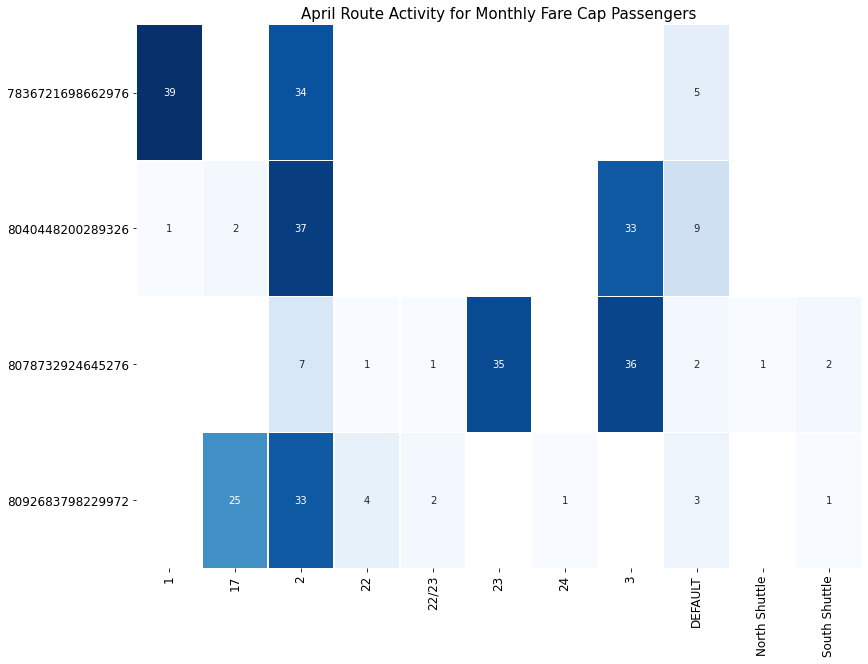

In [75]:
# create heatmap of passenger activity for the month of April
plt.figure(figsize=(13,10))
ax = sns.heatmap(
    monthly_cap_by_route.unstack()['Count'], cmap='Blues', annot=True, linewidths=0.2, cbar=False
)
plt.title('April Route Activity for Monthly Fare Cap Passengers', fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

The heatmap above shows us that these four passengers ride two routes very often while other routes are not utilized as much. We might assume that these other routes represent trips other than commuting but further analysis should be conducted to confirm such a claim. 






Let's wrap up what we've learned from the data set. 

Out of 835 unique card numbers in the month of April, only 4 reached their monthly fare cap. Those four passengers reached their fare cap in the last few days of the month. On average, these passengers completed 4 transactions a day. We saw examples of passengers coming from Winston-Salem, Greensboro, and High Point. We also saw some pretty unusual and unique travel behavior that is difficult to understand without knowing where the passengers got off the bus. 